In [ ]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 33.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pyvi.ViTokenizer import ViTokenizer
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, MaxPool1D, Bidirectional, LSTM, GRU, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text, sequence
from keras import backend as K
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [ ]:

from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
DIR_ROOT = '/content/gdrive/MyDrive/NLP/'
DIR_DATASET = os.path.join(DIR_ROOT, 'dataset')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')

STOPWORDS_PATH = os.path.join(DIR_ROOT, 'vietnamese-stopwords-dash.txt')
EMBEDDING_PATH = os.path.join(DIR_ROOT, 'cc.vi.300.vec')
TOKENIZER_PATH = os.path.join(DIR_ROOT, 'tokenizer.pickle')
# https://fasttext.cc/docs/en/crawl-vectors.html
MODEL_DIR = os.path.join(DIR_ROOT, 'model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
if os.path.exists(DIR_DATASET):
    print(f"The 'dataset' folder exists in the specified directory.")
else:
    print(f"The 'dataset' folder does not exist in the specified directory.")

The 'dataset' folder exists in the specified directory.


In [ ]:
# Check if the files exist
if os.path.exists(STOPWORDS_PATH):
    print(f"The file 'vietnamese-stopwords-dash.txt' exists at {STOPWORDS_PATH}.")
else:
    print(f"The file 'vietnamese-stopwords-dash.txt' does not exist at {STOPWORDS_PATH}.")

if os.path.exists(EMBEDDING_PATH):
    print(f"The file 'cc.vi.300.vec' exists at {EMBEDDING_PATH}.")
else:
    print(f"The file 'cc.vi.300.vec' does not exist at {EMBEDDING_PATH}.")

if os.path.exists(TOKENIZER_PATH):
    print(f"The file 'tokenizer.pickle' exists at {TOKENIZER_PATH}.")
else:
    print(f"The file 'tokenizer.pickle' does not exist at {TOKENIZER_PATH}.")

The file 'vietnamese-stopwords-dash.txt' exists at /content/gdrive/MyDrive/NLP/vietnamese-stopwords-dash.txt.
The file 'cc.vi.300.vec' exists at /content/gdrive/MyDrive/NLP/cc.vi.300.vec.
The file 'tokenizer.pickle' exists at /content/gdrive/MyDrive/NLP/tokenizer.pickle.


In [ ]:
def show_predict_result(model, X_test, y_test, labels):
    prediction = model.predict(X_test, batch_size=256, verbose=0)
    y_pred = prediction.argmax(axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels , columns = labels)
    sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
data_train = pd.read_csv(PATH_TRAIN)
X_train = data_train.iloc[:, 0:2]
y_train = data_train.iloc[:, 2:4]

data_dev = pd.read_csv(PATH_DEV)
X_dev = data_dev.iloc[:, 0:2]
y_dev = data_dev.iloc[:, 2:4]


data_test = pd.read_csv(PATH_TEST)
X_test = data_test.iloc[:, 0:2]
y_test = data_test.iloc[:, 2:4]

In [ ]:
with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [ ]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text


def pre_process_features(X, y1, y2, tokenized = True, lowercased = True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            X = np.delete(X, idx)
            y1 = np.delete(y1, idx)
            y2 = np.delete(y2, idx)
    return X, y1, y2


def make_featues(X, y1, y2, tokenizer, is_one_hot_label=True, number_class1=2, number_class2=4):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y1 = to_categorical(y1, num_classes=number_class1)
        y2 = to_categorical(y2, num_classes=number_class2)

    return X, y1, y2

In [ ]:
train_X, train_y, train_y_spam = pre_process_features(X_train['Comment'], y_train['Label'], y_train['SpamLabel'], tokenized=True, lowercased = False)
dev_X, dev_y, dev_y_spam = pre_process_features(X_dev['Comment'], y_dev['Label'], y_dev['SpamLabel'], tokenized=True, lowercased = False)
test_X, test_y, test_y_spam = pre_process_features(X_test['Comment'], y_test['Label'], y_test['SpamLabel'], tokenized=True, lowercased = False)

In [ ]:

embeddings_index = {}
with open(EMBEDDING_PATH, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
labels_task_1 = ["no-spam", "spam"]
labels_task_2 = ["no-spam", "spam-1", "spam-2", "spam-3"]

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:

train_X, train_y, train_y_spam = make_featues(train_X, train_y, train_y_spam, tokenizer)
dev_X, dev_y, dev_y_spam = make_featues(dev_X, dev_y, dev_y_spam, tokenizer)
test_X, test_y, test_y_spam = make_featues(test_X, test_y, test_y_spam, tokenizer, is_one_hot_label=False)

Text CNN

In [ ]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 300)             6033000   ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 100, 300, 1)          0         ['embedding[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 99, 1, 32)            19232     ['reshape[0][0]']             
                                                                                              

In [ ]:
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y))

Epoch 1/40
56/56 [==============================] - 27s 241ms/step - loss: 0.6559 - accuracy: 0.6238 - val_loss: 0.5696 - val_accuracy: 0.7319
Epoch 2/40
56/56 [==============================] - 10s 174ms/step - loss: 0.5465 - accuracy: 0.7473 - val_loss: 0.5279 - val_accuracy: 0.7306
Epoch 3/40
56/56 [==============================] - 7s 125ms/step - loss: 0.5180 - accuracy: 0.7459 - val_loss: 0.5127 - val_accuracy: 0.7319
Epoch 4/40
56/56 [==============================] - 8s 152ms/step - loss: 0.4997 - accuracy: 0.7595 - val_loss: 0.5011 - val_accuracy: 0.7407
Epoch 5/40
56/56 [==============================] - 4s 74ms/step - loss: 0.4871 - accuracy: 0.7889 - val_loss: 0.4907 - val_accuracy: 0.7709
Epoch 6/40
56/56 [==============================] - 6s 103ms/step - loss: 0.4744 - accuracy: 0.7997 - val_loss: 0.4814 - val_accuracy: 0.7804
Epoch 7/40
56/56 [==============================] - 5s 90ms/step - loss: 0.4625 - accuracy: 0.8061 - val_loss: 0.4723 - val_accuracy: 0.7860
Epoch 

In [ ]:
TEXT_CNN_MODEL = os.path.join(MODEL_DIR, 'Text_CNN_task1.h5')
model.save(TEXT_CNN_MODEL, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


F1 - micro: 0.830478589420655
F1 - macro: 0.7653964892494867
Accuracy: 0.8304785894206549


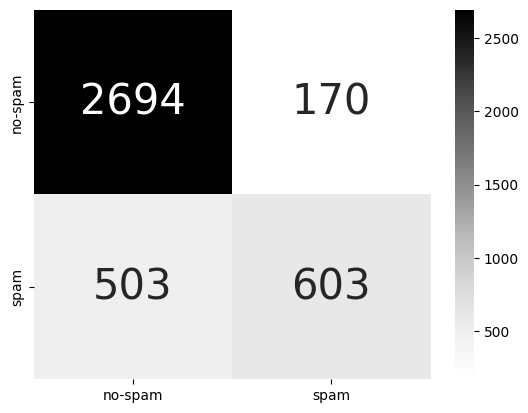

In [ ]:
show_predict_result(model, test_X, test_y, labels_task_1)

In [ ]:

inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 300)             6033000   ['input_2[0][0]']             
                                                                                                  
 reshape_1 (Reshape)         (None, 100, 300, 1)          0         ['embedding_1[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)           (None, 99, 1, 32)            19232     ['reshape_1[0][0]']           
                                                                                            

In [ ]:
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y_spam,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y_spam))

Epoch 1/40
56/56 [==============================] - 10s 159ms/step - loss: 1.0347 - accuracy: 0.6584 - val_loss: 0.8429 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 6s 102ms/step - loss: 0.8019 - accuracy: 0.7451 - val_loss: 0.7555 - val_accuracy: 0.7332
Epoch 3/40
56/56 [==============================] - 7s 132ms/step - loss: 0.7366 - accuracy: 0.7519 - val_loss: 0.7136 - val_accuracy: 0.7388
Epoch 4/40
56/56 [==============================] - 5s 80ms/step - loss: 0.6909 - accuracy: 0.7741 - val_loss: 0.6831 - val_accuracy: 0.7458
Epoch 5/40
56/56 [==============================] - 4s 74ms/step - loss: 0.6596 - accuracy: 0.7939 - val_loss: 0.6591 - val_accuracy: 0.7772
Epoch 6/40
56/56 [==============================] - 5s 85ms/step - loss: 0.6312 - accuracy: 0.8028 - val_loss: 0.6394 - val_accuracy: 0.7804
Epoch 7/40
56/56 [==============================] - 3s 50ms/step - loss: 0.6102 - accuracy: 0.8046 - val_loss: 0.6225 - val_accuracy: 0.7848
Epoch 8/4

In [ ]:

TEXT_CNN_MODEL = os.path.join(MODEL_DIR, 'Text_CNN_task2.h5')
model.save(TEXT_CNN_MODEL, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


F1 - micro: 0.8312342569269522
F1 - macro: 0.6504811203819556
Accuracy: 0.8312342569269522


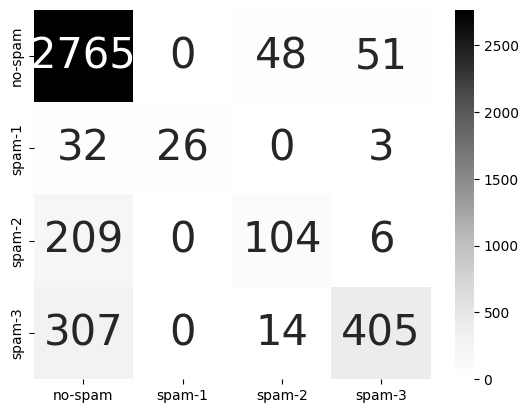

In [ ]:
show_predict_result(model, test_X, test_y_spam, labels_task_2)

Bi LSTM

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(2, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 100, 300)             6033000   ['input_3[0][0]']             
                                                                                                  
 spatial_dropout1d (Spatial  (None, 100, 300)             0         ['embedding_2[0][0]']         
 Dropout1D)                                                                                       
                                                                                                  
 bidirectional (Bidirection  (None, 100, 128)             186880    ['spatial_dropout1d[0][0

In [ ]:
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y))

Epoch 1/40
56/56 [==============================] - 14s 140ms/step - loss: 0.6602 - accuracy: 0.6689 - val_loss: 0.6121 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 7s 134ms/step - loss: 0.5608 - accuracy: 0.7400 - val_loss: 0.5468 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 6s 101ms/step - loss: 0.5212 - accuracy: 0.7403 - val_loss: 0.5201 - val_accuracy: 0.7294
Epoch 4/40
56/56 [==============================] - 4s 66ms/step - loss: 0.4891 - accuracy: 0.7500 - val_loss: 0.4855 - val_accuracy: 0.7451
Epoch 5/40
56/56 [==============================] - 5s 99ms/step - loss: 0.4590 - accuracy: 0.7827 - val_loss: 0.4648 - val_accuracy: 0.8018
Epoch 6/40
56/56 [==============================] - 4s 64ms/step - loss: 0.4285 - accuracy: 0.8289 - val_loss: 0.4461 - val_accuracy: 0.8112
Epoch 7/40
56/56 [==============================] - 4s 63ms/step - loss: 0.4000 - accuracy: 0.8349 - val_loss: 0.4437 - val_accuracy: 0.8143
Epoch 8/4

In [ ]:
BILSTM_MODEL = os.path.join(MODEL_DIR, 'BiLSTM_task1.h5')
model.save(BILSTM_MODEL, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


F1 - micro: 0.8206549118387909
F1 - macro: 0.7531561093915322
Accuracy: 0.8206549118387909


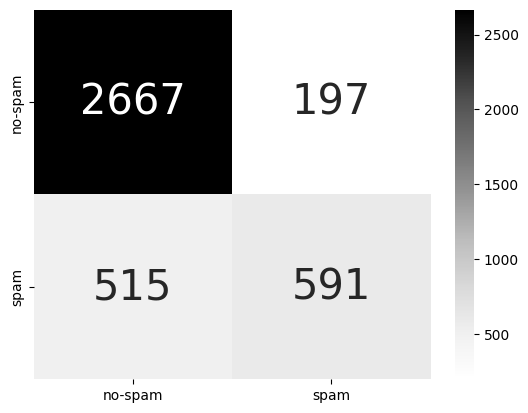

In [ ]:
show_predict_result(model, test_X, test_y, labels_task_1)

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(4, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 100, 300)             6033000   ['input_4[0][0]']             
                                                                                                  
 spatial_dropout1d_1 (Spati  (None, 100, 300)             0         ['embedding_3[0][0]']         
 alDropout1D)                                                                                     
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 100, 128)             186880    ['spatial_dropout1d_1[0]

In [ ]:
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y_spam,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y_spam))

Epoch 1/40
56/56 [==============================] - 13s 135ms/step - loss: 1.2475 - accuracy: 0.6467 - val_loss: 1.0612 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 7s 129ms/step - loss: 0.8592 - accuracy: 0.7402 - val_loss: 0.7916 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 5s 96ms/step - loss: 0.7409 - accuracy: 0.7403 - val_loss: 0.7485 - val_accuracy: 0.7288
Epoch 4/40
56/56 [==============================] - 5s 91ms/step - loss: 0.7050 - accuracy: 0.7412 - val_loss: 0.7197 - val_accuracy: 0.7294
Epoch 5/40
56/56 [==============================] - 6s 104ms/step - loss: 0.6702 - accuracy: 0.7530 - val_loss: 0.6810 - val_accuracy: 0.7489
Epoch 6/40
56/56 [==============================] - 4s 64ms/step - loss: 0.6256 - accuracy: 0.7981 - val_loss: 0.6448 - val_accuracy: 0.7930
Epoch 7/40
56/56 [==============================] - 3s 55ms/step - loss: 0.5881 - accuracy: 0.8119 - val_loss: 0.6205 - val_accuracy: 0.7986
Epoch 8/4

In [ ]:
BILSTM_MODEL = os.path.join(MODEL_DIR, 'BiLSTM_task2.h5')
model.save(BILSTM_MODEL, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


F1 - micro: 0.809823677581864
F1 - macro: 0.6095034518499783
Accuracy: 0.809823677581864


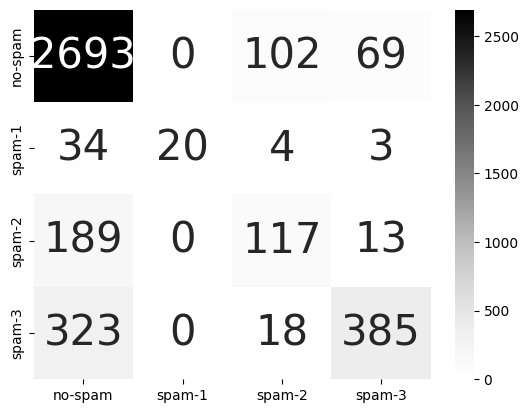

In [ ]:
show_predict_result(model, test_X, test_y_spam, labels_task_2)

GRU

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(2, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 100, 300)             6033000   ['input_5[0][0]']             
                                                                                                  
 spatial_dropout1d_2 (Spati  (None, 100, 300)             0         ['embedding_4[0][0]']         
 alDropout1D)                                                                                     
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 100, 160)             183360    ['spatial_dropout1d_2[0]

In [ ]:
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y))

Epoch 1/40
56/56 [==============================] - 14s 166ms/step - loss: 0.6236 - accuracy: 0.7381 - val_loss: 0.5811 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 6s 99ms/step - loss: 0.5468 - accuracy: 0.7400 - val_loss: 0.5415 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 7s 126ms/step - loss: 0.5175 - accuracy: 0.7403 - val_loss: 0.5190 - val_accuracy: 0.7288
Epoch 4/40
56/56 [==============================] - 5s 83ms/step - loss: 0.4917 - accuracy: 0.7449 - val_loss: 0.4914 - val_accuracy: 0.7709
Epoch 5/40
56/56 [==============================] - 3s 59ms/step - loss: 0.4662 - accuracy: 0.7968 - val_loss: 0.4692 - val_accuracy: 0.7986
Epoch 6/40
56/56 [==============================] - 3s 58ms/step - loss: 0.4407 - accuracy: 0.8165 - val_loss: 0.4551 - val_accuracy: 0.8093
Epoch 7/40
56/56 [==============================] - 5s 84ms/step - loss: 0.4171 - accuracy: 0.8325 - val_loss: 0.4403 - val_accuracy: 0.8131
Epoch 8/40

In [ ]:
GRU_MODEL = os.path.join(MODEL_DIR, 'GRU_task1.h5')
model.save(GRU_MODEL, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


F1 - micro: 0.8183879093198992
F1 - macro: 0.7568677056468118
Accuracy: 0.8183879093198992


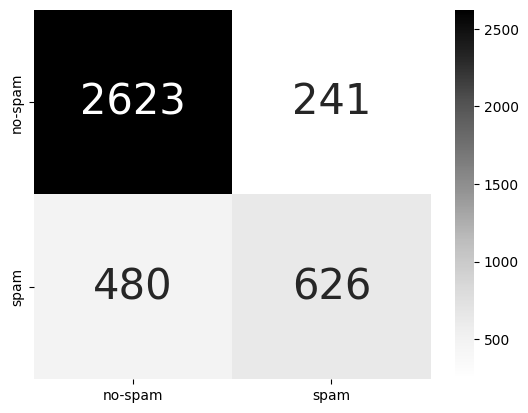

In [ ]:
show_predict_result(model, test_X, test_y, labels_task_1)

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(4, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 100, 300)             6033000   ['input_6[0][0]']             
                                                                                                  
 spatial_dropout1d_3 (Spati  (None, 100, 300)             0         ['embedding_5[0][0]']         
 alDropout1D)                                                                                     
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 100, 160)             183360    ['spatial_dropout1d_3[0]

In [ ]:
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y_spam,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y_spam))

Epoch 1/40
56/56 [==============================] - 13s 156ms/step - loss: 1.1658 - accuracy: 0.6407 - val_loss: 0.9825 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 6s 108ms/step - loss: 0.8424 - accuracy: 0.7400 - val_loss: 0.7771 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 7s 119ms/step - loss: 0.7259 - accuracy: 0.7402 - val_loss: 0.7337 - val_accuracy: 0.7281
Epoch 4/40
56/56 [==============================] - 5s 91ms/step - loss: 0.6912 - accuracy: 0.7410 - val_loss: 0.7060 - val_accuracy: 0.7319
Epoch 5/40
56/56 [==============================] - 4s 74ms/step - loss: 0.6616 - accuracy: 0.7473 - val_loss: 0.6800 - val_accuracy: 0.7413
Epoch 6/40
56/56 [==============================] - 4s 66ms/step - loss: 0.6335 - accuracy: 0.7704 - val_loss: 0.6553 - val_accuracy: 0.7816
Epoch 7/40
56/56 [==============================] - 5s 82ms/step - loss: 0.6051 - accuracy: 0.8081 - val_loss: 0.6335 - val_accuracy: 0.7904
Epoch 8/4

In [ ]:
GRU_MODEL = os.path.join(MODEL_DIR, 'GRU_task2.h5')
model.save(GRU_MODEL, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


F1 - micro: 0.8120906801007556
F1 - macro: 0.6429101101426782
Accuracy: 0.8120906801007557


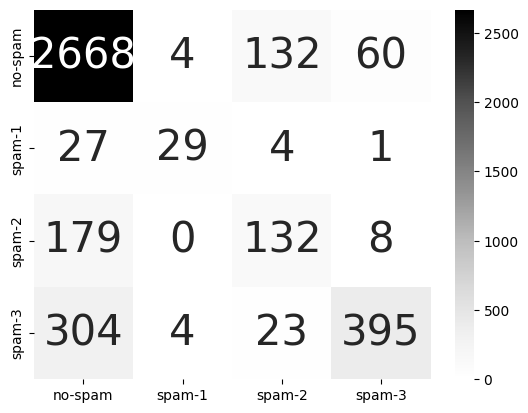

In [ ]:
show_predict_result(model, test_X, test_y_spam, labels_task_2)